In [75]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np


data_folder = "../data"

names = [x for x in os.listdir(data_folder) if not x.endswith("zip")]
discrepancy_data  = []
for name in names:
    
    path = os.path.join(data_folder, name)
    functions = [x for x in os.listdir(path) if x.endswith("json")]
    for filename in functions:
        filepath = os.path.join(path, filename)
        
        with open(filepath) as f:
            text = f.read()
            data = json.loads(text.replace(": inf", ": 0"))
        
        for scen in data['scenarios']:
            *x, cache = data['algorithm']['name'].split("-")
            for run_id, run in enumerate(scen['runs'], 1):
                discrepancy_data.append((
                    data['function_id'], 
                    data['algorithm']['name'],
                    scen['dimension'],
                    run_id, 
                    run['instance'],
                    run['cache_discrepancy'],
                    run['best']['evals'],
                    run['best']['y'],
                    int(cache) if cache.isdigit() else 0
                ))

data = pd.DataFrame(discrepancy_data, 
                    columns=["fid", "alg", "dimension",  
                             "run", "instance", "discrepancy", "evals", "y", "cache_size"])
view = data.query(
    "discrepancy > 0 and not alg.str.contains('mirror') and not alg.str.contains('orthogonal')"
).groupby(["dimension", "alg"])['discrepancy'].mean().unstack().T.sort_index()
view['cache_size'] = view.index.str.rsplit("-").str[-1].astype(int)
view.index = view.index.str.split("-", n=2).str[-1]
view.index = view.index.str.replace("-cache", "")
discr = view.sort_values("cache_size")[[2, 5, 10, 20, 40]]

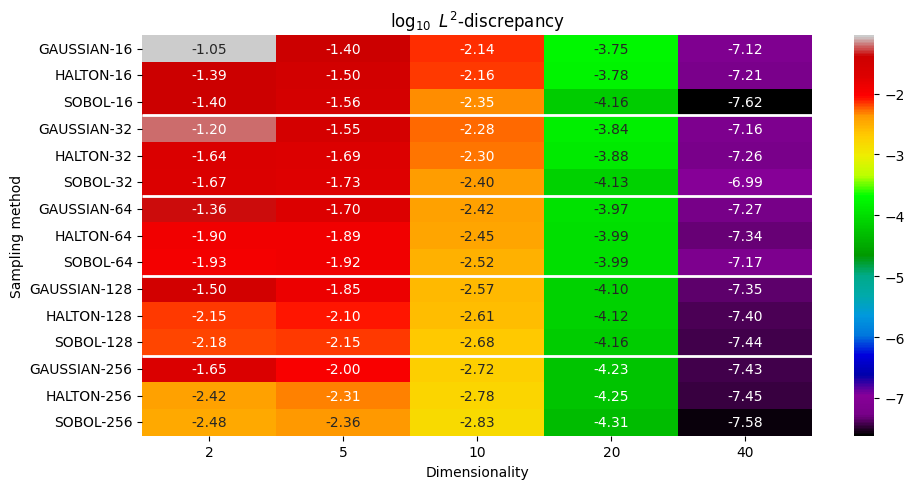

In [8]:
f, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(discr, annot=True, fmt=".2f", cmap="nipy_spectral")

ax.set_ylabel("Sampling method")
ax.set_xlabel("Dimensionality")
ax.set_title(r"$\log_{10}\ L^{2}$-discrepancy")
ax.hlines([3, 6, 9, 12], *ax.get_xlim(), color="white", linewidth=2)
plt.tight_layout()
plt.savefig("../data/figures/discrepancy.pdf")

In [3]:
import sqlite3

con = sqlite3.connect(f"../data/eaf/eaf.db", timeout=20)

view = pd.read_sql(
    '''
    SELECT run_id, fid, dim, sampler, cache_size, budget, eaf
    FROM eaf
    WHERE orthogonal = false AND mirrored = false 
    ''', con)

view 

,run_id,fid,dim,sampler,cache_size,budget,eaf
0,1,7,20,SOBOL,64,2,0.0
1,2,7,20,SOBOL,64,2,0.0
2,3,7,20,SOBOL,64,2,0.0
3,4,7,20,SOBOL,64,2,0.0
4,5,7,20,SOBOL,64,2,0.0
...,...,...,...,...,...,...,...
10329795,96,1,40,SOBOL,16,501187,1.0
10329796,97,1,40,SOBOL,16,501187,1.0
10329797,98,1,40,SOBOL,16,501187,1.0
10329798,99,1,40,SOBOL,16,501187,1.0


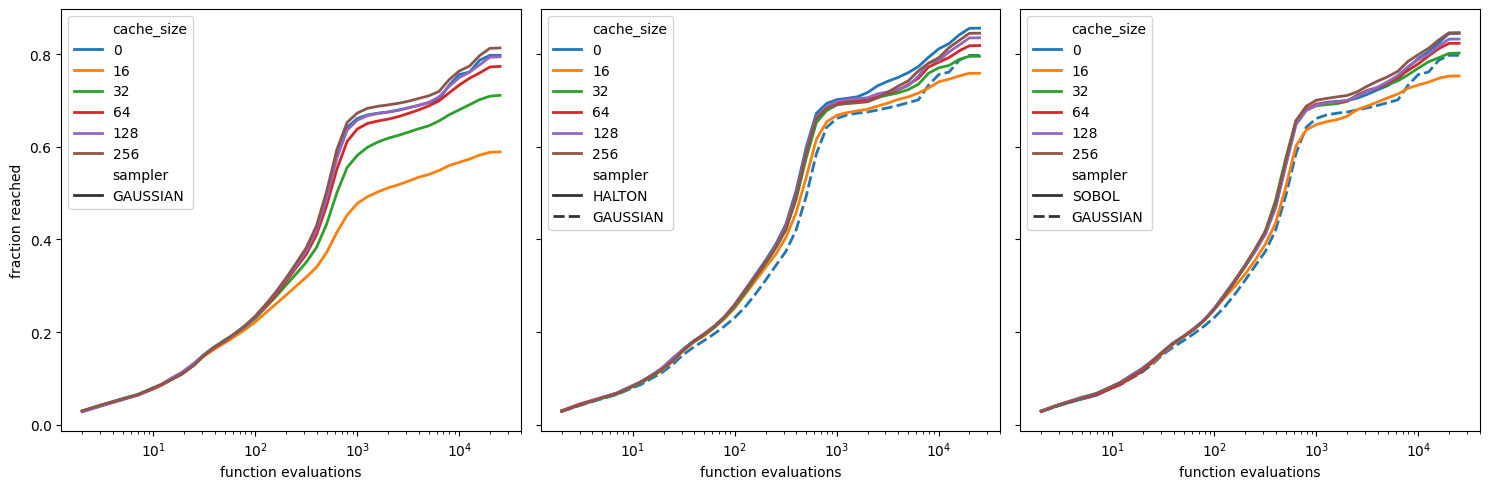

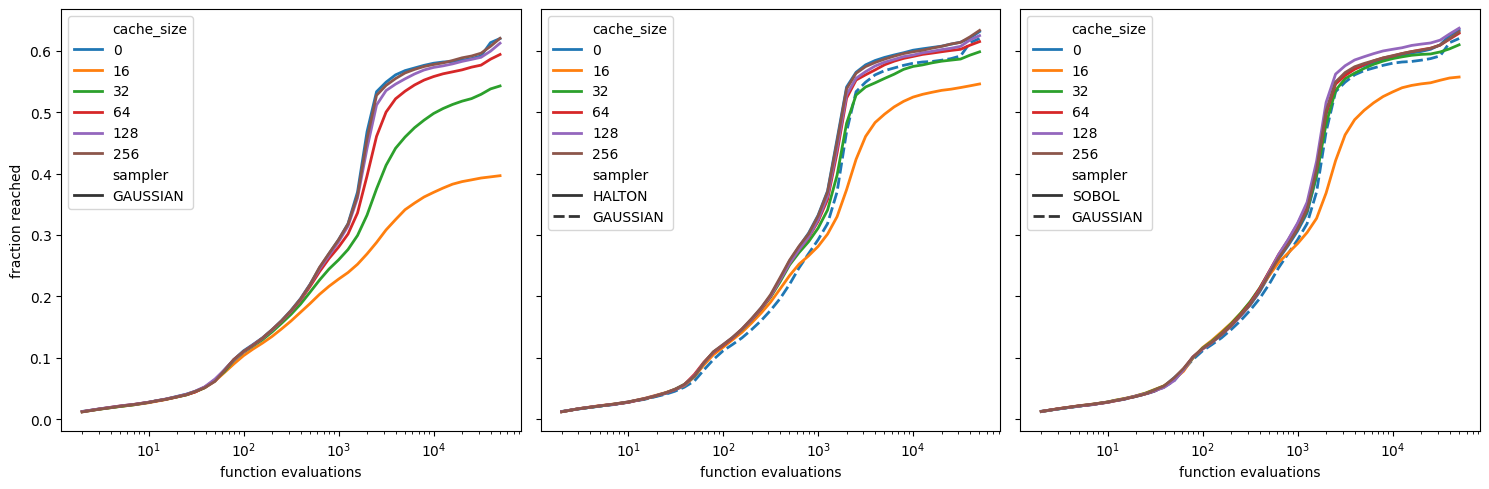

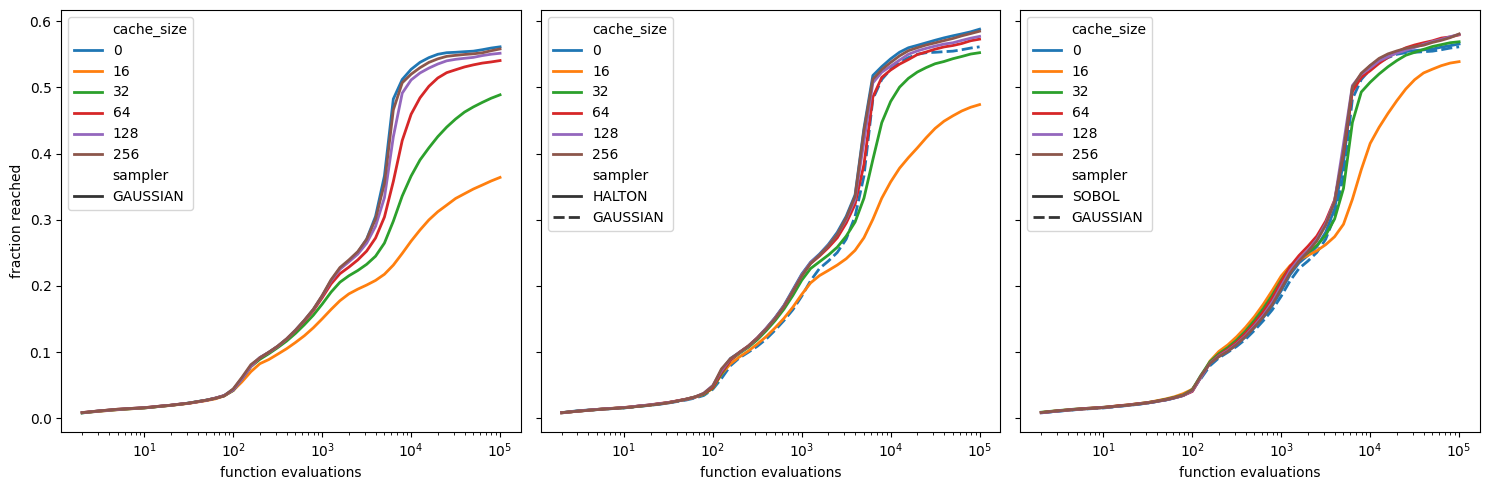

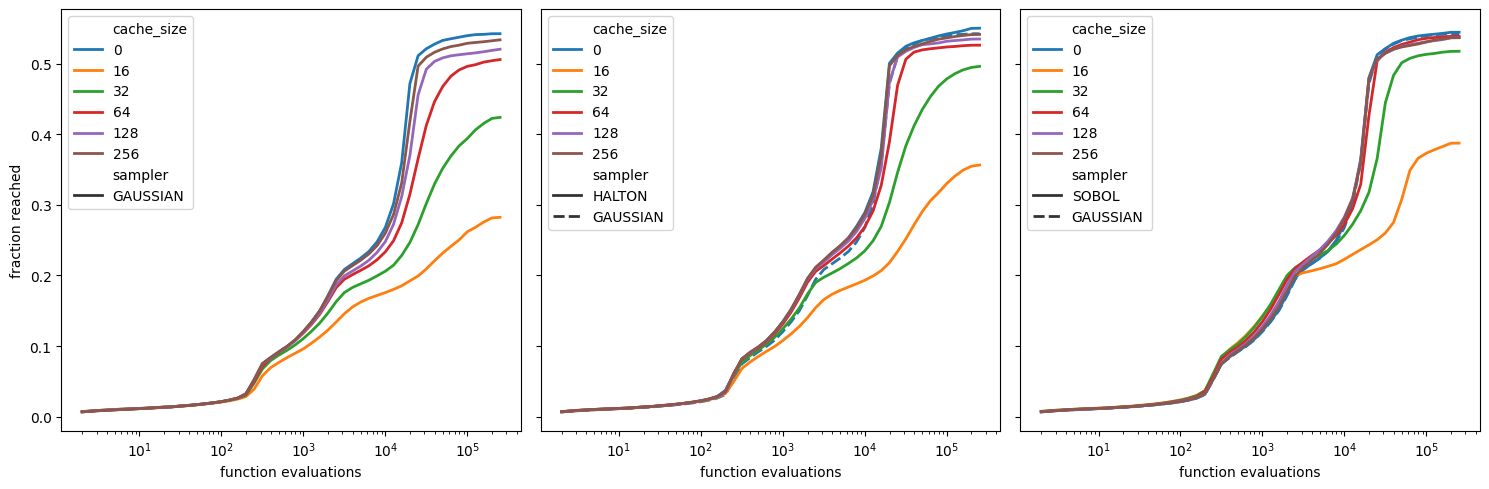

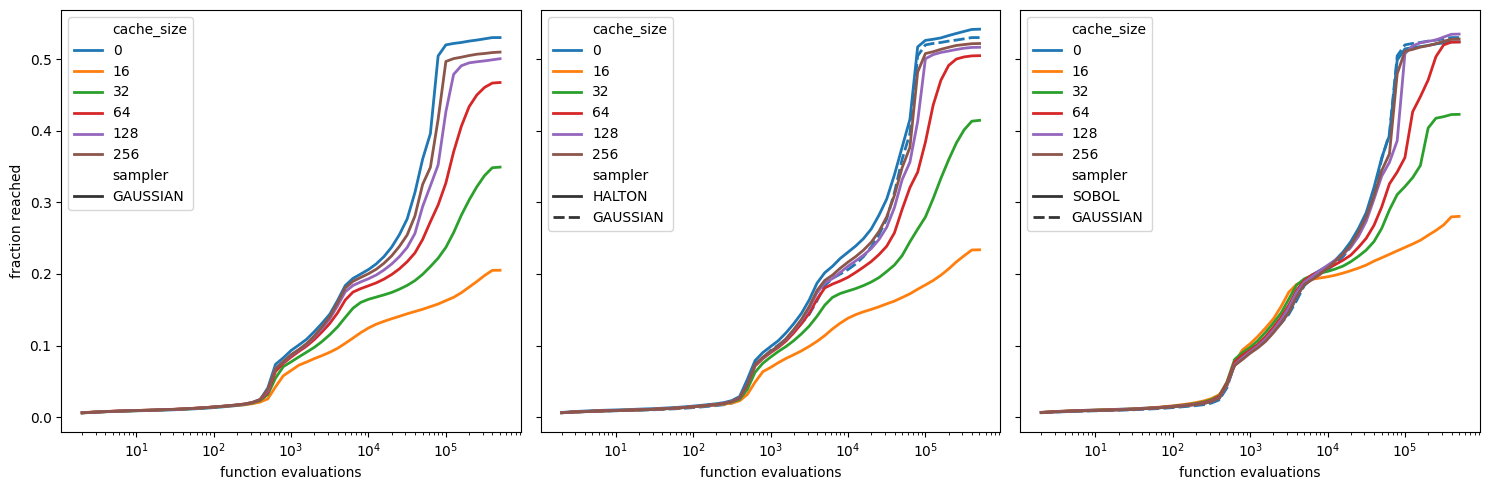

In [4]:
def get_auc(pdata, dim):
    mdata = pdata.groupby("budget")['eaf'].mean()
    max_budget = 10_000 * dim
    mdata[max_budget] = mdata.values[-1]
    mdata = mdata[mdata.index <= max_budget]
    return np.trapz(mdata.values, mdata.index) / max_budget

auc = []
for dim in (2, 5, 10, 20, 40):
    f, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    default_cma = view.query(f"sampler == 'GAUSSIAN' and dim == {dim} and cache_size == 0")
    for sampler, ax in zip(("GAUSSIAN", "HALTON", "SOBOL", ), axes.ravel()):
        pdata  = view.query(f"sampler == '{sampler}' and dim == {dim}").sort_values(["cache_size"])
        for cache_size, auc_data  in pdata.groupby("cache_size"):
            auc.append((dim, f"{sampler}-{cache_size}", get_auc(auc_data, dim)))

        pdata = pd.concat([pdata, default_cma])    
        sns.lineplot(
            pdata,
            x="budget",
            y="eaf",
            hue="cache_size",
            style="sampler",
            errorbar=None,
            palette='tab10',
            lw=2,
            ax=ax
        )
        ax.set_xscale("log")
        # ax.set_title(sampler)
        ax.set_xlabel("function evaluations")
        ax.set_ylabel("fraction reached")
    # f.suptitle(f"Dimensionality {dim}")
    plt.tight_layout()
    plt.savefig(f"../data/figures/eaf_d{dim}.pdf")

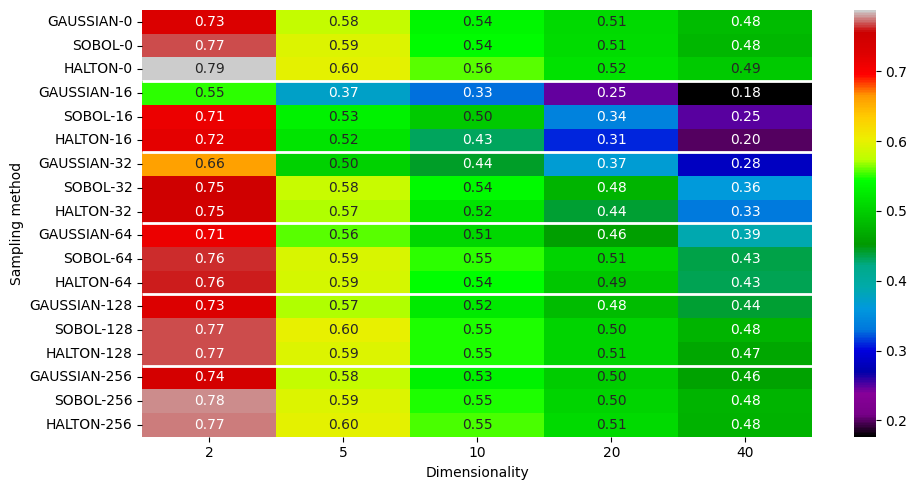

In [5]:
auc_data = pd.DataFrame(auc, columns=['dim', 'sampler', 'auc']).pivot(index="sampler", columns="dim", values="auc")
auc_data = auc_data.sort_values("sampler", key=lambda x:x.str.split("-").str[1].astype(int) + 2 * (x.str[0] == 'H') + 1 * (x.str[0] == 'S'))

f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(auc_data,  annot=True, fmt=".2f", cmap="nipy_spectral")

ax.set_ylabel("Sampling method")
ax.set_xlabel("Dimensionality")
# ax.set_title(r"$\log_{10}\ L^{2}$-discrepancy")
ax.hlines([3, 6, 9, 12, 15], *ax.get_xlim(), color="white", linewidth=2)
plt.tight_layout()

plt.savefig(f"../data/figures/eaf_auc_per_dim.pdf")

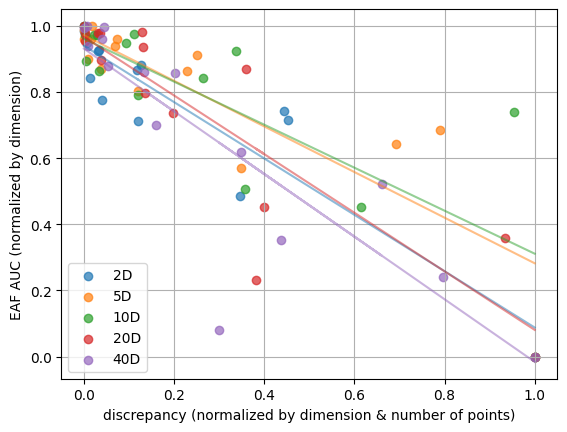

In [117]:
def colnorm(data):
    return (data - data.min()) / (data.max() - data.min())


for dim in (2, 5, 10, 20, 40):
    discrn = discr[dim].values /  np.repeat([16, 32, 64, 128, 256], 3)

    x, y = colnorm(discrn).ravel(), colnorm(auc_data[dim].values[3:])
    
    

    plt.scatter(x, y, label=f"{dim}D", alpha=.7)
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), alpha=.5)
    
    plt.xlabel("discrepancy (normalized by dimension & number of points)")
    plt.ylabel("EAF AUC (normalized by dimension)")
    plt.grid()
    plt.legend()
    plt.savefig("../data/figures/eaf_auc_vs_discrepancy.pdf")

In [163]:
def l_infty_star_discrepancy(points):
    N, d = points.shape
    discrepancy = 0.0
    
    for t in points:
        count = np.sum(np.all(points < t, axis=1))
        volume = np.prod(t)
        discrepancy = max(discrepancy, abs(count / N - volume))
    
    return discrepancy

In [223]:
import time
import ioh
import numpy as np
from scipy.stats.qmc import discrepancy
from scipy.stats import norm

from modcma.c_maes import ModularCMAES, parameters, options, constants, utils
      

linf_data = []
index = []
for cache_size in (16, 32, 64, 128, 256):
    for sampler in (0, 1, 2):
        row = []
        for dim in (2, 5, 10, 20, 40, ):
            linf_discrepancy = 0
            for i in range(100):
                utils.set_seed(1 * dim * i)
                sampler = options.BaseSampler(sampler)
                algorithm_name = f"{sampler.name}"
                    
                modules = parameters.Modules()
                modules.sampler = sampler

                algorithm_name = f"{algorithm_name}-{cache_size}"
                constants.cache_max_doubles = 0
                constants.cache_min_samples = cache_size
                constants.cache_samples = True

                problem = ioh.get_problem(1, 1, dim)
                    
                start = time.perf_counter()
                settings = parameters.Settings(
                    problem.meta_data.n_variables,
                    modules,
                    x0=np.random.uniform(-4, 4, size=dim),
                    sigma0=(problem.bounds.ub[0] - problem.bounds.lb[0]) *.2,
                )

                cma = ModularCMAES(settings)
                
                cached_sample = norm.cdf(np.vstack([cma.p.sampler() for _ in range(cache_size)]))
                # cache_discrepancy = discrepancy(cached_sample, method="L2-star")
                linf_discrepancy += discrepancy(cached_sample, method="L2-star")
                
            # print(algorithm_name, "l2 discrepancy: ", cache_discrepancy)
            # print(algorithm_name, "linf discrepancy: ", linf_discrepancy)
            row.append(linf_discrepancy / 100)
        index.append(algorithm_name)
        linf_data.append(row)   
 
l_inf_descr = pd.DataFrame(np.array(linf_data), columns=[2, 5, 10, 20, 40], index=index)      

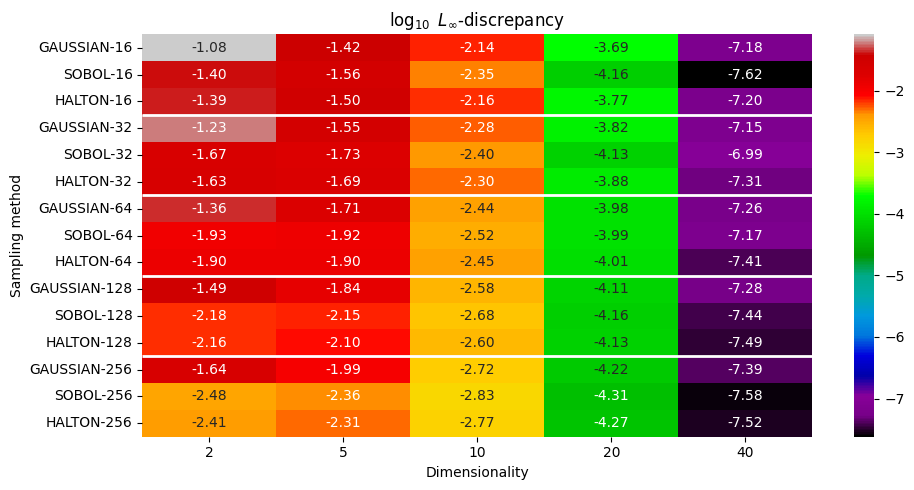

In [224]:
f, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(np.log10(l_inf_descr), annot=True, fmt=".2f", cmap="nipy_spectral")

ax.set_ylabel("Sampling method")
ax.set_xlabel("Dimensionality")
ax.set_title(r"$\log_{10}\ L_{\infty}$-discrepancy")
ax.hlines([3, 6, 9, 12], *ax.get_xlim(), color="white", linewidth=2)
plt.tight_layout()
plt.savefig("../data/figures/linf_discrepancy.pdf")


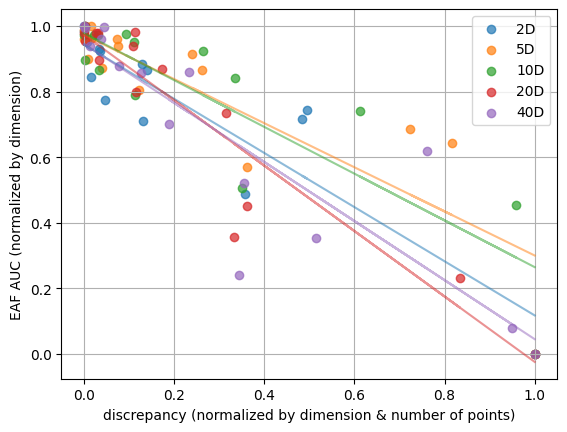

In [225]:
for dim in (2, 5, 10, 20, 40):
    discrn = l_inf_descr[dim].values / np.repeat([16, 32, 64, 128, 256], 3)

    x, y = colnorm(discrn).ravel(), colnorm(auc_data[dim].values[3:])
    
    

    plt.scatter(x, y, label=f"{dim}D", alpha=.7)
    
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), alpha=.5)
    
plt.xlabel("discrepancy (normalized by dimension & number of points)")
plt.ylabel("EAF AUC (normalized by dimension)")
plt.grid()
plt.legend()
    # plt.savefig("../data/figures/eaf_auc_vs_discrepancy.pdf")